# ECG Anomaly Detection with Counterfactual Explanations

3 layer explainable AI pipeline for ECG anomaly detection:

1. Detection layer - Ensemble of Isolation Forest and OCSVM
2. Counterfactual layer - uses nearest neighbour approach to generate counterfactual explanations
3. Explanation layer: LLM (open ai) powered clinical translations of the counterfactual explanations

## Dataset
ECG200 dataset from the UCR Time Series Archive:
- 200 ECG samples (100 train, 100 test)
- Class 1 = Normal heartbeats
- Class -1 = Myocardial infarction

## Setup

In [1]:
!pip install wfdb numpy pandas scipy scikit-learn matplotlib seaborn openai tqdm

import numpy as np
import pandas as pd
from pathlib import Path
import warnings
import time
import os
from scipy import signal
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cdist, euclidean
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    roc_curve, precision_recall_curve
)
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import json
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
from tqdm import tqdm
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Dependencies loaded successfully")

Dependencies loaded successfully


## Pipeline Configuration

In [2]:
@dataclass
class PipelineConfig:
    # Data 
    sampling_rate: int = 100    # Hz (ECG200 is variable) (PTBXL uses 100Hz/500Hz)
    signal_length: int = 96 # ECG200 has 96 timesteps per sample
    n_leads: int = 1    # ECG200 is single lead

    # Preprocessing 
    lowcut: float = 0.5   # high pass filter cutoff
    highcut: float = 40.0 # low pass filter cutoff
    filter_order: int = 4

    # Anomaly detection 
    contamination: float = 0.1  # expected proportion of anomalies
    if_n_estimators: int = 100  # Isolation Forest trees
    svm_kernel: str = 'rbf' # OCSVM kernel
    svm_nu: float = 0.1 # OCSVM nu parameter
    svm_gamma: str = 'scale'    # OCSM gamma

    # Counterfactual 
    n_neighbors: int = 5    # 5 nearest neighbours
    distance_metric: str = 'euclidean'

    # LLM 
    llm_backend: str = 'openai'                    
    llm_model: str = 'gpt-4o-mini'  # model to use
    llm_temperature: float = 0.2    # lower for more consistent outputs
    llm_max_tokens: int = 512
    llm_api_key_env: str = 'OPENAI_KEY'       
    
    # llm_local_model: str = 'Qwen/Qwen2.5-0.5B-Instruct'
    # llm_local_cache_dir: str = '/tmp/hf_cache'
    
    data_dir: str = './data'
    output_dir: str = './outputs'

config = PipelineConfig()
print(f"Pipeline configured with: {config}")

Pipeline configured with: PipelineConfig(sampling_rate=100, signal_length=96, n_leads=1, lowcut=0.5, highcut=40.0, filter_order=4, contamination=0.1, if_n_estimators=100, svm_kernel='rbf', svm_nu=0.1, svm_gamma='scale', n_neighbors=5, distance_metric='euclidean', llm_backend='openai', llm_model='gpt-4o-mini', llm_temperature=0.2, llm_max_tokens=512, llm_api_key_env='OPENAI_KEY', data_dir='./data', output_dir='./outputs')


## Data Loading & Preprocessing

In [3]:
class ECGDataLoader:
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.scaler = StandardScaler()
    
    # ECG200 contains 200 ECG samples:
        #   Class 1 = Normal 
        #   Class -1 = Myocardial infarction
    def load_ecg200(self, train_path: str, test_path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        # In ECG200 first column is label, rest is time series 
        train_data = np.loadtxt(train_path)
        test_data = np.loadtxt(test_path)
        
        y_train = train_data[:, 0]
        X_train = train_data[:, 1:]
        y_test = test_data[:, 0]
        X_test = test_data[:, 1:]
        
        # convert the labels 1 -> 0 (normal) and -1 -> 1 (anomaly)
        y_train = np.where(y_train == 1, 0, 1)
        y_test = np.where(y_test == 1, 0, 1)
        
        print(f"ECG200 loaded:")
        print(f"  Training: {X_train.shape[0]} samples, {X_train.shape[1]} timesteps")
        print(f"  Test: {X_test.shape[0]} samples")
        print(f"  Normal (train): {np.sum(y_train == 0)}, Anomaly (train): {np.sum(y_train == 1)}")
        
        return X_train, X_test, y_train, y_test

In [4]:
# Bandpass filtering, normalisation and quality checks.
class ECGPreprocessor:
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.scaler = StandardScaler()
    
    # Butterworth bandpass filter to remove baseline wander and high frequency noise
    def bandpass_filter(self, X: np.ndarray) -> np.ndarray:
        # High pass (0.5 Hz): removes baseline wander from respiration
        # Low-pass (40 Hz): removes muscle noise and powerline interference

        nyquist = self.config.sampling_rate / 2
        low = self.config.lowcut / nyquist
        high = self.config.highcut / nyquist
        
        if high >= 1.0:
            high = 0.99
        if low <= 0.0:
            low = 0.01
            
        b, a = signal.butter(self.config.filter_order, [low, high], btype='band')
        
        if X.ndim == 1:
            return signal.filtfilt(b, a, X)
        elif X.ndim == 2:
            return np.array([signal.filtfilt(b, a, x) for x in X])
        else:
            filtered = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[2]):
                    filtered[i, :, j] = signal.filtfilt(b, a, X[i, :, j])
            return filtered
    
    # z score normalisation
    def normalize(self, X: np.ndarray, fit: bool = True) -> np.ndarray:
        if X.ndim == 1:
            return (X - np.mean(X)) / (np.std(X) + 1e-8)
        elif X.ndim == 2:
            return np.array([(x - np.mean(x)) / (np.std(x) + 1e-8) for x in X])
        else:
            normalized = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[2]):
                    sig = X[i, :, j]
                    normalized[i, :, j] = (sig - np.mean(sig)) / (np.std(sig) + 1e-8)
            return normalized
    
    def preprocess(self, X: np.ndarray, apply_filter: bool = True) -> np.ndarray:
        X_processed = X.copy()
        
        if apply_filter:
            X_processed = self.bandpass_filter(X_processed)
        
        X_processed = self.normalize(X_processed)
        
        return X_processed

In [5]:
# load ECG200 data
loader = ECGDataLoader(config)
preprocessor = ECGPreprocessor(config)

X_train_raw, X_test_raw, y_train, y_test = loader.load_ecg200(
     'data/ECG200/ECG200_TRAIN.txt',
     'data/ECG200/ECG200_TEST.txt'
)

# preprocess
X_train = preprocessor.preprocess(X_train_raw)
X_test = preprocessor.preprocess(X_test_raw)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Anomaly ratio (train): {np.mean(y_train):.2%}")
print(f"Anomaly ratio (test): {np.mean(y_test):.2%}")

ECG200 loaded:
  Training: 100 samples, 96 timesteps
  Test: 100 samples
  Normal (train): 69, Anomaly (train): 31

Train set: 100 samples
Test set: 100 samples
Anomaly ratio (train): 31.00%
Anomaly ratio (test): 36.00%


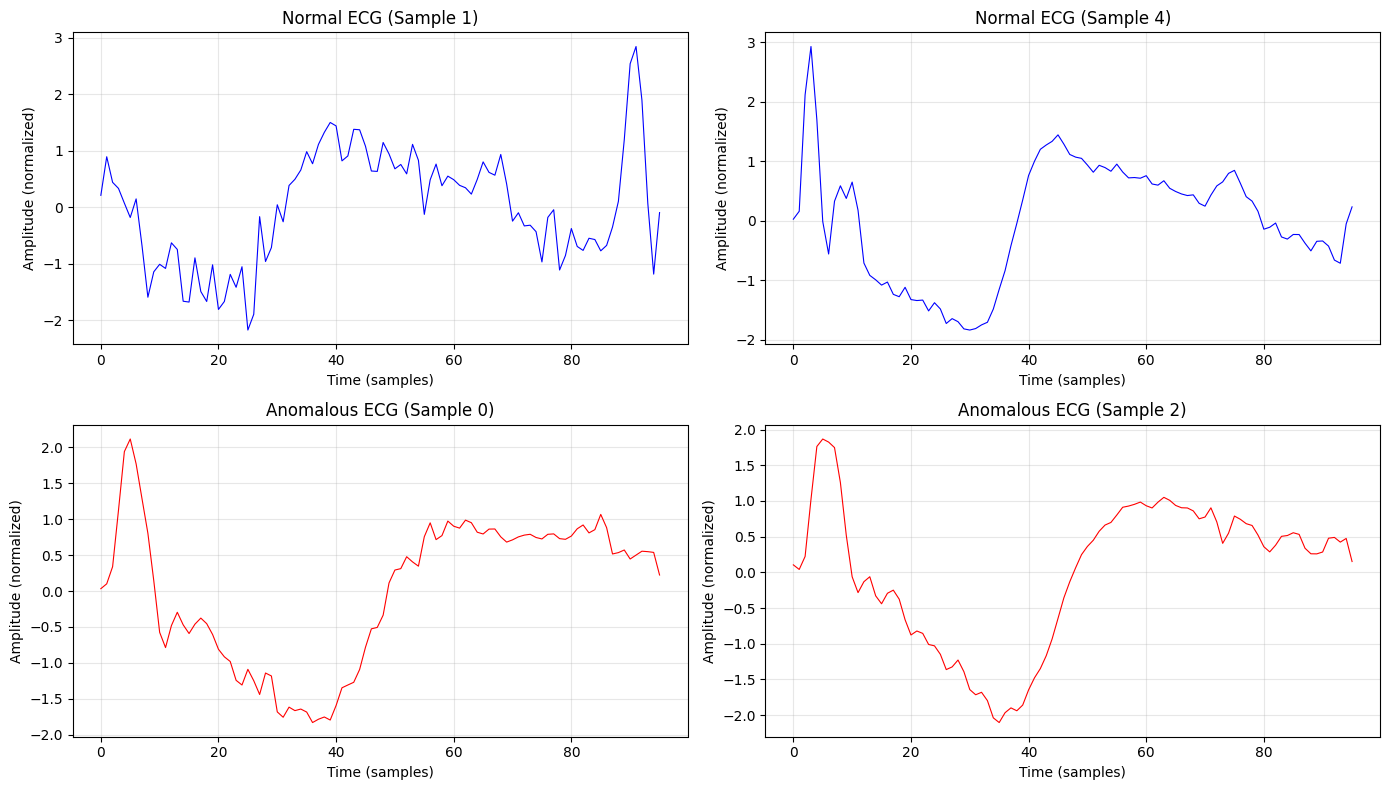

In [6]:
# visualise Sample ECGs
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

normal_idx = np.where(y_train == 0)[0][:2]
anomaly_idx = np.where(y_train == 1)[0][:2]

for i, idx in enumerate(normal_idx):
    axes[0, i].plot(X_train[idx], 'b-', linewidth=0.8)
    axes[0, i].set_title(f'Normal ECG (Sample {idx})', fontsize=12)
    axes[0, i].set_xlabel('Time (samples)')
    axes[0, i].set_ylabel('Amplitude (normalized)')
    axes[0, i].grid(True, alpha=0.3)

for i, idx in enumerate(anomaly_idx):
    axes[1, i].plot(X_train[idx], 'r-', linewidth=0.8)
    axes[1, i].set_title(f'Anomalous ECG (Sample {idx})', fontsize=12)
    axes[1, i].set_xlabel('Time (samples)')
    axes[1, i].set_ylabel('Amplitude (normalized)')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ecg_samples.png', dpi=150, bbox_inches='tight')
plt.show()

## Feature Extraction

Extract clinically relevant features from the ECGs
- Statistical features
- Temporal/morphological features
- Frequency domain features

In [7]:
class ECGFeatureExtractor:
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.feature_names = []
    
    # statistical features
    def extract_statistical_features(self, x: np.ndarray) -> Dict[str, float]:
        return {
            'mean': np.mean(x),
            'std': np.std(x),
            'var': np.var(x),
            'min': np.min(x),
            'max': np.max(x),
            'range': np.max(x) - np.min(x),
            'median': np.median(x),
            'skewness': skew(x),
            'kurtosis': kurtosis(x),
            'rms': np.sqrt(np.mean(x**2)),
            'zero_crossings': np.sum(np.diff(np.signbit(x)))
        }
    
    # temporal/morphological features 
    def extract_temporal_features(self, x: np.ndarray) -> Dict[str, float]:
        threshold = np.mean(x) + 0.5 * np.std(x)
        peaks, properties = signal.find_peaks(x, height=threshold, distance=10)
        
        features = {}
        
        if len(peaks) > 1:
            rr_intervals = np.diff(peaks)
            features['rr_mean'] = np.mean(rr_intervals)
            features['rr_std'] = np.std(rr_intervals)
            features['rr_min'] = np.min(rr_intervals)
            features['rr_max'] = np.max(rr_intervals)
            features['hr_estimate'] = 60 * self.config.sampling_rate / np.mean(rr_intervals)
            features['hrv'] = np.std(rr_intervals) / (np.mean(rr_intervals) + 1e-8)
        else:
            features['rr_mean'] = 0
            features['rr_std'] = 0
            features['rr_min'] = 0
            features['rr_max'] = 0
            features['hr_estimate'] = 0
            features['hrv'] = 0
        
        features['n_peaks'] = len(peaks)
        if len(peaks) > 0:
            peak_heights = x[peaks]
            features['peak_height_mean'] = np.mean(peak_heights)
            features['peak_height_std'] = np.std(peak_heights)
        else:
            features['peak_height_mean'] = 0
            features['peak_height_std'] = 0
        
        return features
    
    # frequency domain features using fft
    def extract_frequency_features(self, x: np.ndarray) -> Dict[str, float]:
        fft_vals = np.abs(np.fft.rfft(x))
        fft_freq = np.fft.rfftfreq(len(x), d=1/self.config.sampling_rate)
        
        total_power = np.sum(fft_vals**2) + 1e-8
        
        vlf_mask = (fft_freq >= 0) & (fft_freq < 0.04)
        lf_mask = (fft_freq >= 0.04) & (fft_freq < 0.15)
        hf_mask = (fft_freq >= 0.15) & (fft_freq < 0.4)
        
        features = {
            'total_power': total_power,
            'vlf_power': np.sum(fft_vals[vlf_mask]**2) / total_power,
            'lf_power': np.sum(fft_vals[lf_mask]**2) / total_power,
            'hf_power': np.sum(fft_vals[hf_mask]**2) / total_power,
            'dominant_freq': fft_freq[np.argmax(fft_vals)] if len(fft_vals) > 0 else 0,
            'spectral_entropy': -np.sum((fft_vals/total_power) * np.log(fft_vals/total_power + 1e-8))
        }
        
        features['lf_hf_ratio'] = features['lf_power'] / (features['hf_power'] + 1e-8)
        
        return features
    
    # extract all features from a single ECG 
    def extract_all_features(self, x: np.ndarray) -> np.ndarray:
        features = {}
        features.update(self.extract_statistical_features(x))
        features.update(self.extract_temporal_features(x))
        features.update(self.extract_frequency_features(x))
        
        if not self.feature_names:
            self.feature_names = list(features.keys())
        
        return np.array(list(features.values()))
    
    # extract all features from multiple ECG signals
    def transform(self, X: np.ndarray) -> np.ndarray:
        if X.ndim == 1:
            return self.extract_all_features(X).reshape(1, -1)
        elif X.ndim == 2:
            return np.array([self.extract_all_features(x) for x in X])
        else:
            return np.array([self.extract_all_features(x[:, 0]) for x in X])

In [8]:
# extract the features
feature_extractor = ECGFeatureExtractor(config)

X_train_features = feature_extractor.transform(X_train)
X_test_features = feature_extractor.transform(X_test)

print(f"Feature matrix shape: {X_train_features.shape}")
print(f"\nExtracted features ({len(feature_extractor.feature_names)}):")
for i, name in enumerate(feature_extractor.feature_names):
    print(f"  {i+1}. {name}")

Feature matrix shape: (100, 27)

Extracted features (27):
  1. mean
  2. std
  3. var
  4. min
  5. max
  6. range
  7. median
  8. skewness
  9. kurtosis
  10. rms
  11. zero_crossings
  12. rr_mean
  13. rr_std
  14. rr_min
  15. rr_max
  16. hr_estimate
  17. hrv
  18. n_peaks
  19. peak_height_mean
  20. peak_height_std
  21. total_power
  22. vlf_power
  23. lf_power
  24. hf_power
  25. dominant_freq
  26. spectral_entropy
  27. lf_hf_ratio


In [9]:
# scale the features
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_features)
X_test_scaled = feature_scaler.transform(X_test_features)

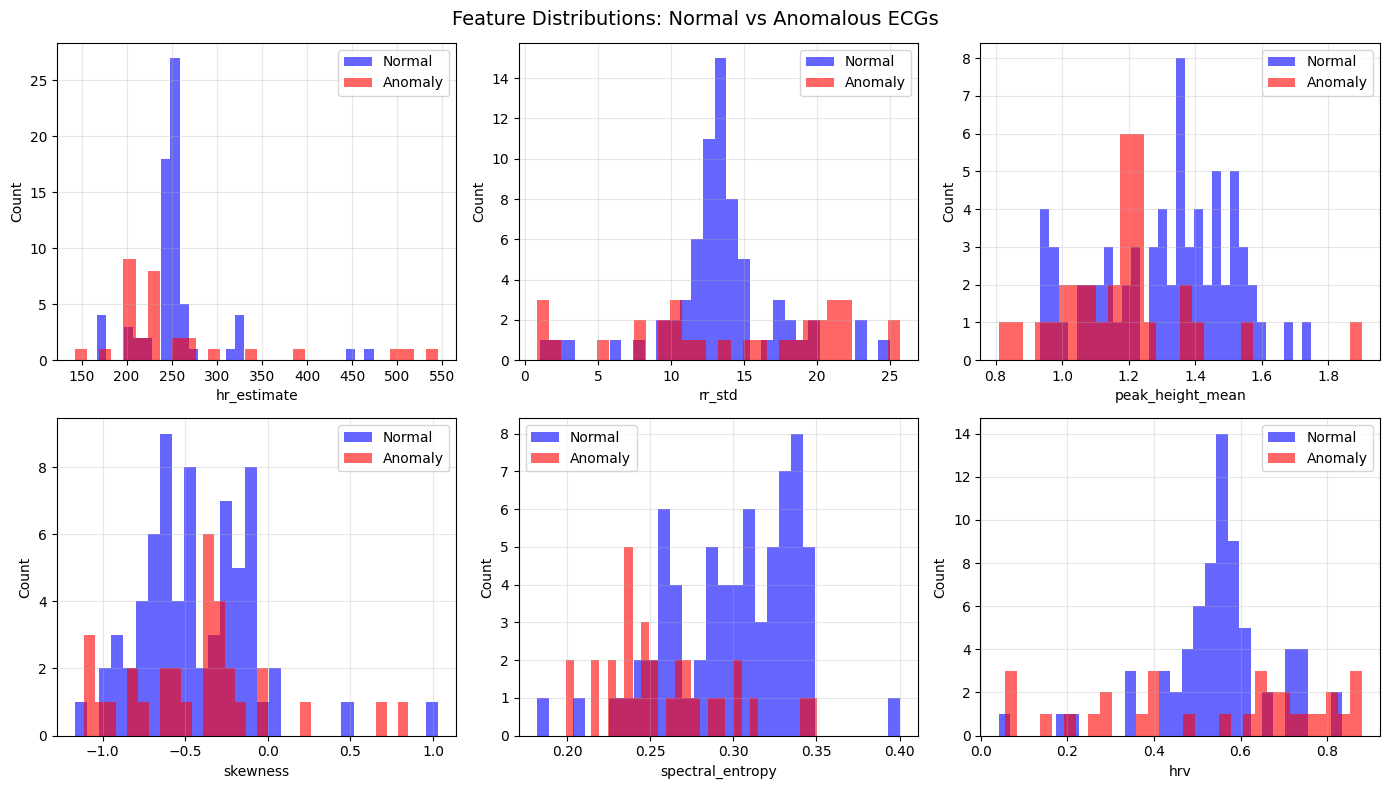

In [10]:
# visualise Feature Distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
key_features = ['hr_estimate', 'rr_std', 'peak_height_mean', 'skewness', 'spectral_entropy', 'hrv']

for ax, feat_name in zip(axes.flat, key_features):
    if feat_name in feature_extractor.feature_names:
        feat_idx = feature_extractor.feature_names.index(feat_name)
        
        normal_vals = X_train_features[y_train == 0, feat_idx]
        anomaly_vals = X_train_features[y_train == 1, feat_idx]
        
        ax.hist(normal_vals, bins=30, alpha=0.6, label='Normal', color='blue')
        ax.hist(anomaly_vals, bins=30, alpha=0.6, label='Anomaly', color='red')
        ax.set_xlabel(feat_name)
        ax.set_ylabel('Count')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle('Feature Distributions: Normal vs Anomalous ECGs', fontsize=14)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## Anomaly Detection

In [11]:
class AnomalyDetector(ABC):
    
    @abstractmethod
    def fit(self, X: np.ndarray) -> 'AnomalyDetector':
        pass
    
    @abstractmethod
    def predict(self, X: np.ndarray) -> np.ndarray:
        pass
    
    @abstractmethod
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        pass

In [12]:
# Isolation Forest anomaly detection
class IsolationForestDetector(AnomalyDetector):
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.model = IsolationForest(
            n_estimators=config.if_n_estimators,
            contamination=config.contamination,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        self.threshold = None
        
    def fit(self, X: np.ndarray) -> 'IsolationForestDetector':
        self.model.fit(X)
        scores = self.model.decision_function(X)
        self.threshold = np.percentile(scores, 100 * self.config.contamination)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        preds = self.model.predict(X)
        return np.where(preds == 1, 0, 1)
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        return -self.model.decision_function(X)

In [13]:
# One Class SVM anomaly detection
class OneClassSVMDetector(AnomalyDetector):
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.model = OneClassSVM(
            kernel=config.svm_kernel,
            nu=config.svm_nu,
            gamma=config.svm_gamma
        )
        self.threshold = None
        
    def fit(self, X: np.ndarray) -> 'OneClassSVMDetector':
        self.model.fit(X)
        scores = self.model.decision_function(X)
        self.threshold = np.percentile(scores, 100 * self.config.contamination)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        preds = self.model.predict(X)
        return np.where(preds == 1, 0, 1)
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        return -self.model.decision_function(X)

In [14]:
# Combination (OCSVM and IF) of anomaly detectors
class EnsembleAnomalyDetector(AnomalyDetector):
    def __init__(self, detectors: List[AnomalyDetector], aggregation: str = 'mean'):
        self.detectors = detectors
        self.aggregation = aggregation
        
    def fit(self, X: np.ndarray) -> 'EnsembleAnomalyDetector':
        for detector in self.detectors:
            detector.fit(X)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = np.array([d.predict(X) for d in self.detectors])
        if self.aggregation == 'voting':
            return (np.mean(predictions, axis=0) >= 0.5).astype(int)
        else:
            scores = self.decision_function(X)
            return (scores > 0).astype(int)
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        scores = np.array([d.decision_function(X) for d in self.detectors])
        return np.mean(scores, axis=0)

In [15]:
# Evaluate the detector
def evaluate_detector(detector: AnomalyDetector, X_test: np.ndarray, y_test: np.ndarray, 
                      detector_name: str) -> Dict[str, float]:
    y_pred = detector.predict(X_test)
    scores = detector.decision_function(X_test)
    
    metrics = {
        'AUROC': roc_auc_score(y_test, scores),
        'AUPRC': average_precision_score(y_test, scores),
        'F1': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0)
    }
    
    print(f"\n{'='*50}")
    print(f"{detector_name} Results:")
    print(f"{'='*50}")
    for name, value in metrics.items():
        print(f"  {name}: {value:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n  Confusion Matrix:")
    print(f"  TN={cm[0,0]}, FP={cm[0,1]}")
    print(f"  FN={cm[1,0]}, TP={cm[1,1]}")
    
    return metrics

In [16]:
# train the detectors
if_detector = IsolationForestDetector(config)
X_train_normal = X_train_scaled[y_train == 0]
print(f"Training Isolation Forest on {len(X_train_normal)} normal samples...")
if_detector.fit(X_train_normal)
if_metrics = evaluate_detector(if_detector, X_test_scaled, y_test, "Isolation Forest")

Training Isolation Forest on 69 normal samples...

Isolation Forest Results:
  AUROC: 0.7938
  AUPRC: 0.6711
  F1: 0.5161
  Precision: 0.6154
  Recall: 0.4444

  Confusion Matrix:
  TN=54, FP=10
  FN=20, TP=16


In [17]:
svm_detector = OneClassSVMDetector(config)
print(f"Training One-Class SVM on {len(X_train_normal)} normal samples...")
svm_detector.fit(X_train_normal)
svm_metrics = evaluate_detector(svm_detector, X_test_scaled, y_test, "One-Class SVM")

Training One-Class SVM on 69 normal samples...

One-Class SVM Results:
  AUROC: 0.7917
  AUPRC: 0.6722
  F1: 0.6531
  Precision: 0.5161
  Recall: 0.8889

  Confusion Matrix:
  TN=34, FP=30
  FN=4, TP=32


In [18]:
ensemble_detector = EnsembleAnomalyDetector(
    detectors=[if_detector, svm_detector],
    aggregation='mean'
)
ensemble_metrics = evaluate_detector(ensemble_detector, X_test_scaled, y_test, "Ensemble (IF + OC-SVM)")


Ensemble (IF + OC-SVM) Results:
  AUROC: 0.8003
  AUPRC: 0.6779
  F1: 0.6818
  Precision: 0.5769
  Recall: 0.8333

  Confusion Matrix:
  TN=42, FP=22
  FN=6, TP=30


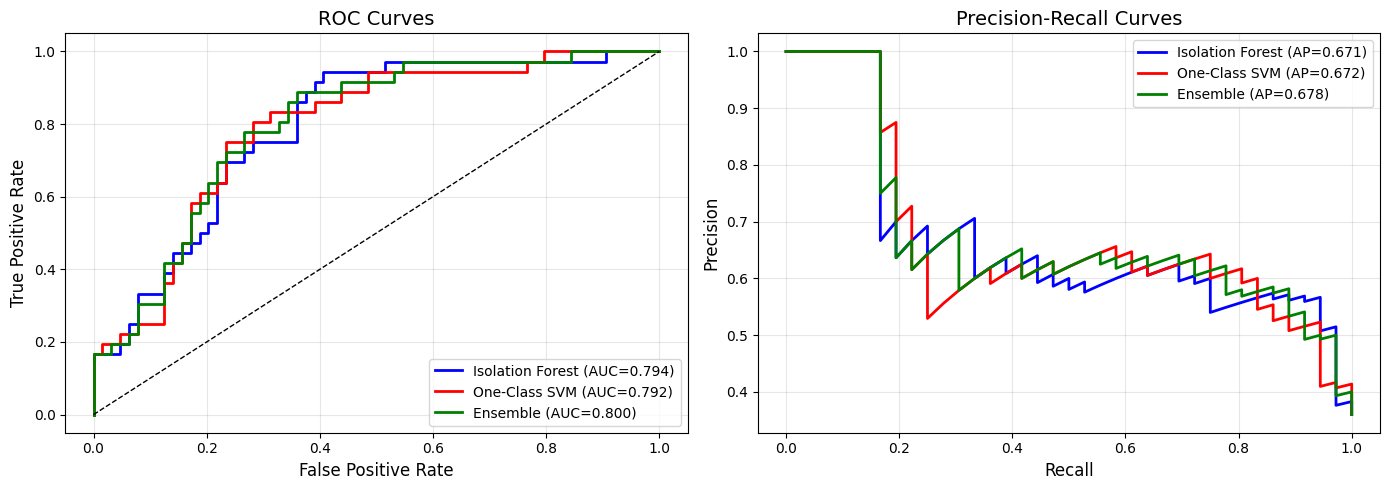

In [19]:
# visualise ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for detector, name, color in [
    (if_detector, 'Isolation Forest', 'blue'),
    (svm_detector, 'One-Class SVM', 'red'),
    (ensemble_detector, 'Ensemble', 'green')
]:
    scores = detector.decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=color, linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves', fontsize=14)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

for detector, name, color in [
    (if_detector, 'Isolation Forest', 'blue'),
    (svm_detector, 'One-Class SVM', 'red'),
    (ensemble_detector, 'Ensemble', 'green')
]:
    scores = detector.decision_function(X_test_scaled)
    precision, recall, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    axes[1].plot(recall, precision, label=f'{name} (AP={ap:.3f})', color=color, linewidth=2)

axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curves', fontsize=14)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('detection_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## Counterfactual Explanations

In [20]:
@dataclass
class CounterfactualExplanation:
    # original information
    original_signal: np.ndarray
    original_features: np.ndarray
    original_prediction: int
    original_score: float
    
    # counterfactual information
    counterfactual_signal: np.ndarray
    counterfactual_features: np.ndarray
    counterfactual_prediction: int
    counterfactual_score: float
    
    # difference analysis
    feature_differences: Dict[str, float] = field(default_factory=dict)
    signal_distance: float = 0.0
    feature_distance: float = 0.0
    
    # quality metrics
    validity: bool = False
    proximity: float = 0.0
    sparsity: int = 0
    
    # Top features that changed
    top_changes: List[Tuple[str, float, float, float]] = field(default_factory=list)

    @property
    def feature_changes(self) -> Dict[str, float]:
        return self.feature_differences

In [21]:
# nearest neighbour counterfactual generator
class NearestNeighbourCounterfactual:    
    def __init__(self, config: PipelineConfig, detector: AnomalyDetector,
                 feature_names: List[str]):
        self.config = config
        self.detector = detector
        self.feature_names = feature_names
        self.nn_model = None
        self.normal_signals = None
        self.normal_features = None

    # Fit the nearest neighbour model on normal samples 
    def fit(self, X_signals: np.ndarray, X_features: np.ndarray, y: np.ndarray):
        normal_mask = (y == 0)
        self.normal_signals = X_signals[normal_mask]
        self.normal_features = X_features[normal_mask]
        
        self.nn_model = NearestNeighbors(
            n_neighbors=self.config.n_neighbors,
            metric=self.config.distance_metric
        )
        self.nn_model.fit(self.normal_features)
        
        print(f"Counterfactual generator fitted on {len(self.normal_signals)} normal samples")

    # Generate cfe for a single sample
    def generate(self, signal: np.ndarray, features: np.ndarray) -> CounterfactualExplanation:
        original_pred = self.detector.predict(features.reshape(1, -1))[0]
        original_score = self.detector.decision_function(features.reshape(1, -1))[0]
        
        distances, indices = self.nn_model.kneighbors(features.reshape(1, -1))
        
        cf_idx = indices[0, 0]
        cf_signal = self.normal_signals[cf_idx]
        cf_features = self.normal_features[cf_idx]
        
        cf_pred = self.detector.predict(cf_features.reshape(1, -1))[0]
        cf_score = self.detector.decision_function(cf_features.reshape(1, -1))[0]
        
        feature_diffs = {}
        for i, name in enumerate(self.feature_names):
            feature_diffs[name] = cf_features[i] - features[i]
        
        signal_dist = euclidean(signal.flatten(), cf_signal.flatten())
        feature_dist = distances[0, 0]
        
        validity = (original_pred == 1) and (cf_pred == 0)
        
        std_threshold = 1.0
        sparsity = sum(1 for diff in feature_diffs.values() if abs(diff) > std_threshold)
        
        sorted_changes = sorted(
            [(name, features[i], cf_features[i], diff) 
             for i, (name, diff) in enumerate(feature_diffs.items())],
            key=lambda x: abs(x[3]),
            reverse=True
        )
        
        return CounterfactualExplanation(
            original_signal=signal,
            original_features=features,
            original_prediction=original_pred,
            original_score=original_score,
            counterfactual_signal=cf_signal,
            counterfactual_features=cf_features,
            counterfactual_prediction=cf_pred,
            counterfactual_score=cf_score,
            feature_differences=feature_diffs,
            signal_distance=signal_dist,
            feature_distance=feature_dist,
            validity=validity,
            proximity=feature_dist,
            sparsity=sparsity,
            top_changes=sorted_changes[:5]
        )
    
    # generate cfe for multiple samples
    def generate_batch(self, signals: np.ndarray, features: np.ndarray) -> List[CounterfactualExplanation]:
        return [self.generate(s, f) for s, f in tqdm(zip(signals, features), total=len(signals))]

In [22]:
def visualize_counterfactual(cf: CounterfactualExplanation, title: str = ""):
    fig = plt.figure(figsize=(16, 10))
    
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(cf.original_signal, 'r-', label='Original (Anomaly)', linewidth=1.5, alpha=0.8)
    ax1.plot(cf.counterfactual_signal, 'b-', label='Counterfactual (Normal)', linewidth=1.5, alpha=0.8)
    ax1.set_xlabel('Time (samples)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('ECG Signal Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = fig.add_subplot(2, 2, 2)
    diff = cf.original_signal - cf.counterfactual_signal
    ax2.fill_between(range(len(diff)), diff, alpha=0.5, color='purple')
    ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax2.set_xlabel('Time (samples)')
    ax2.set_ylabel('Difference')
    ax2.set_title('Signal Difference (Original - Counterfactual)')
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(2, 2, 3)
    top_n = min(5, len(cf.top_changes))
    names = [c[0] for c in cf.top_changes[:top_n]]
    orig_vals = [c[1] for c in cf.top_changes[:top_n]]
    cf_vals = [c[2] for c in cf.top_changes[:top_n]]
    
    x = np.arange(top_n)
    width = 0.35
    ax3.bar(x - width/2, orig_vals, width, label='Original', color='red', alpha=0.7)
    ax3.bar(x + width/2, cf_vals, width, label='Counterfactual', color='blue', alpha=0.7)
    ax3.set_xticks(x)
    ax3.set_xticklabels(names, rotation=45, ha='right')
    ax3.set_ylabel('Feature Value (scaled)')
    ax3.set_title('Top Feature Changes')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.axis('off')
    
    metrics_text = f"""
    COUNTERFACTUAL QUALITY METRICS
    {'='*40}
    
    Validity: {'✓ VALID' if cf.validity else '✗ INVALID'}
    (Prediction flipped from anomaly to normal)
    
    Proximity: {cf.proximity:.4f}
    (Distance to counterfactual in feature space)
    
    Sparsity: {cf.sparsity} features changed significantly
    (Features with |diff| > 1 std)
    
    Original Score: {cf.original_score:.4f}
    Counterfactual Score: {cf.counterfactual_score:.4f}
    
    TOP CHANGES:
    """
    
    for name, orig, cf_val, diff in cf.top_changes[:3]:
        direction = "↑" if diff > 0 else "↓"
        metrics_text += f"\n    • {name}: {orig:.2f} → {cf_val:.2f} ({direction} {abs(diff):.2f})"
    
    ax4.text(0.1, 0.9, metrics_text, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(title or 'Counterfactual Explanation', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [23]:
# initialise cf generator
cf_generator = NearestNeighbourCounterfactual(
    config=config,
    detector=ensemble_detector,
    feature_names=feature_extractor.feature_names
)

cf_generator.fit(X_train, X_train_scaled, y_train)

Counterfactual generator fitted on 69 normal samples


In [24]:
# generate counterfactuals for anomalous samples
anomaly_test_idx = np.where(y_test == 1)[0]
print(f"Generating counterfactuals for {len(anomaly_test_idx)} anomalous samples...")

n_examples = min(10, len(anomaly_test_idx))
sample_indices = anomaly_test_idx[:n_examples]

counterfactuals = []
for idx in sample_indices:
    cf = cf_generator.generate(X_test[idx], X_test_scaled[idx])
    counterfactuals.append(cf)

print(f"\nCounterfactual Quality Summary:")
print(f"  Validity Rate: {sum(cf.validity for cf in counterfactuals) / len(counterfactuals):.2%}")
print(f"  Mean Proximity: {np.mean([cf.proximity for cf in counterfactuals]):.4f}")
print(f"  Mean Sparsity: {np.mean([cf.sparsity for cf in counterfactuals]):.1f} features")

Generating counterfactuals for 36 anomalous samples...

Counterfactual Quality Summary:
  Validity Rate: 80.00%
  Mean Proximity: 7.2285
  Mean Sparsity: 7.5 features


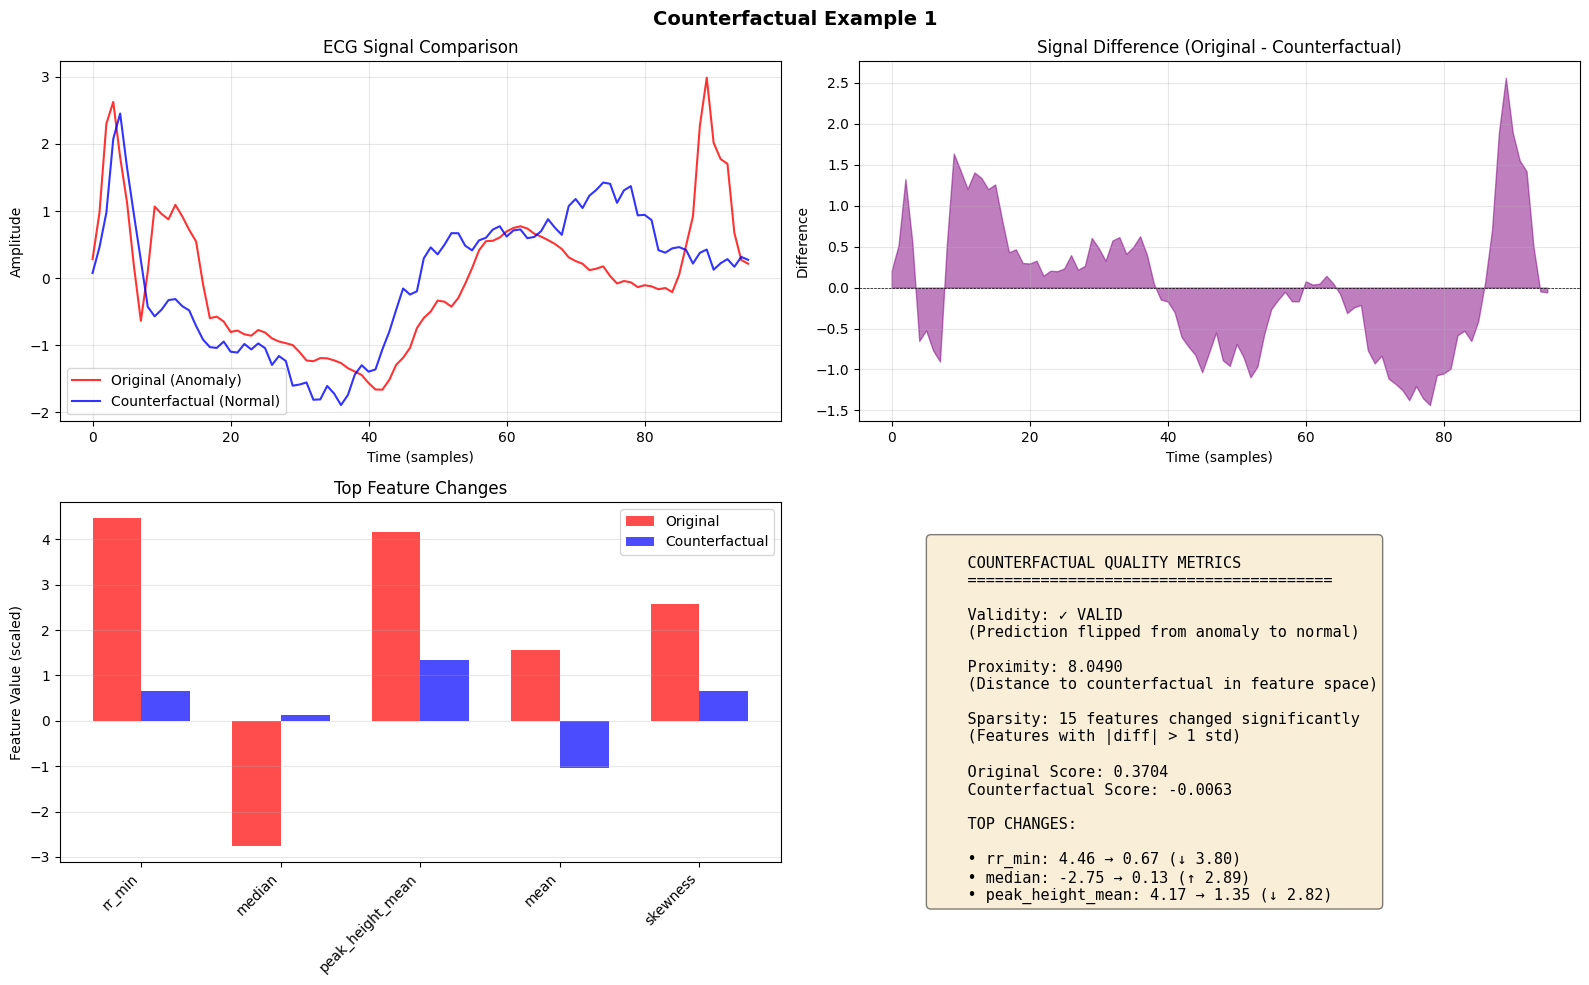

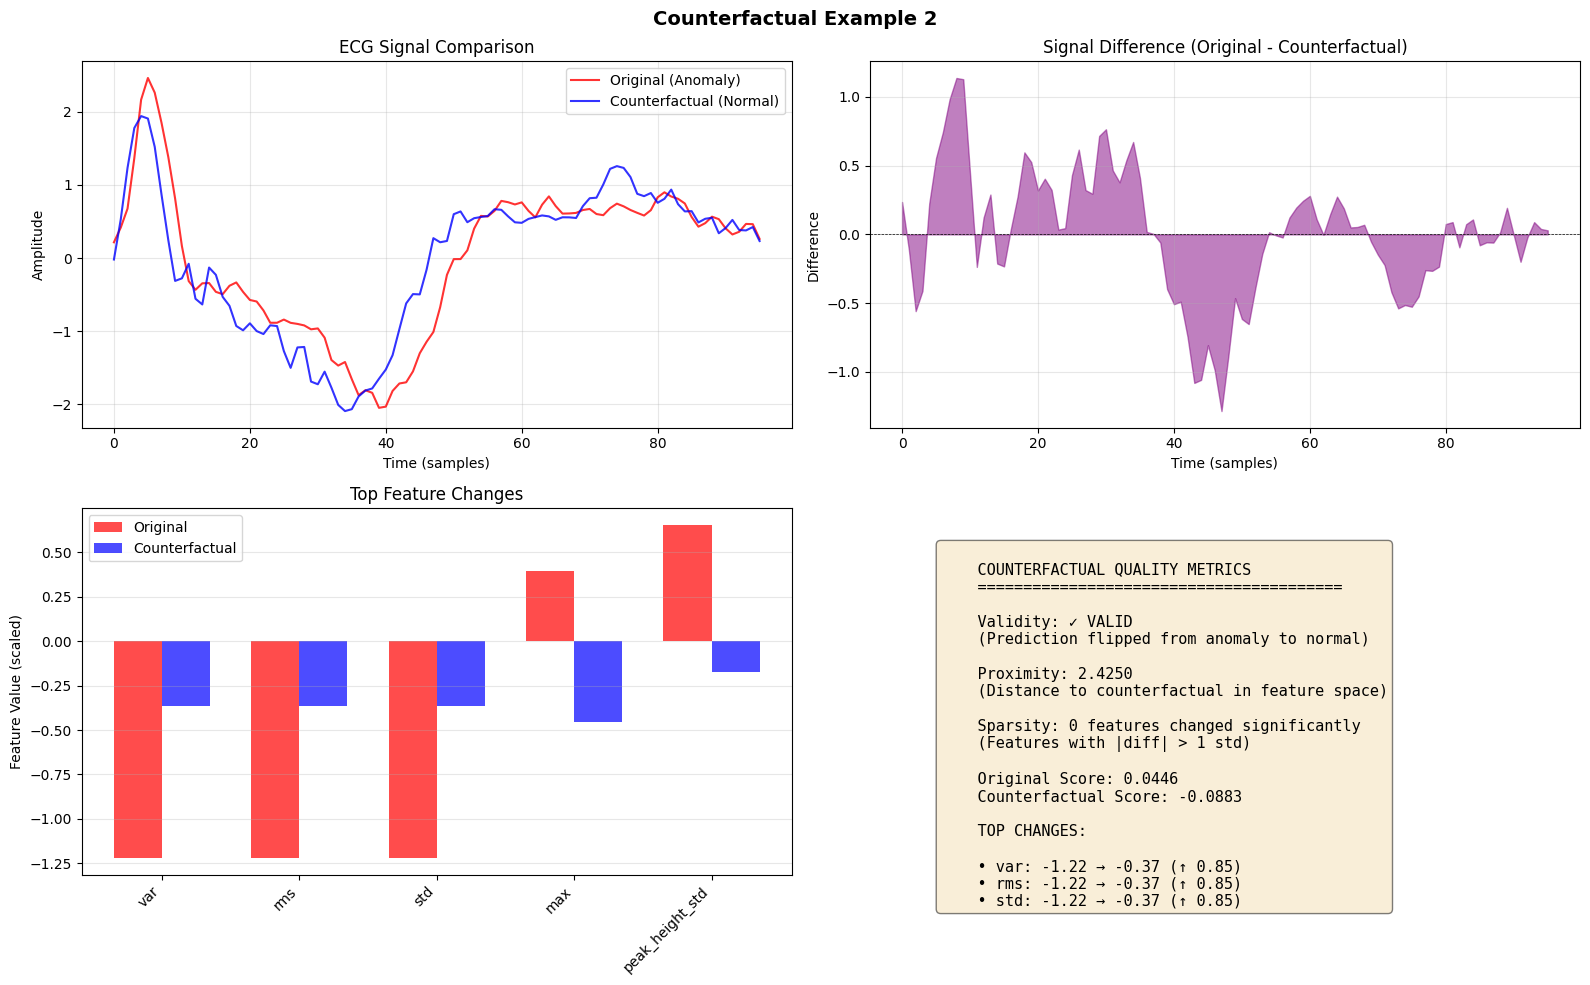

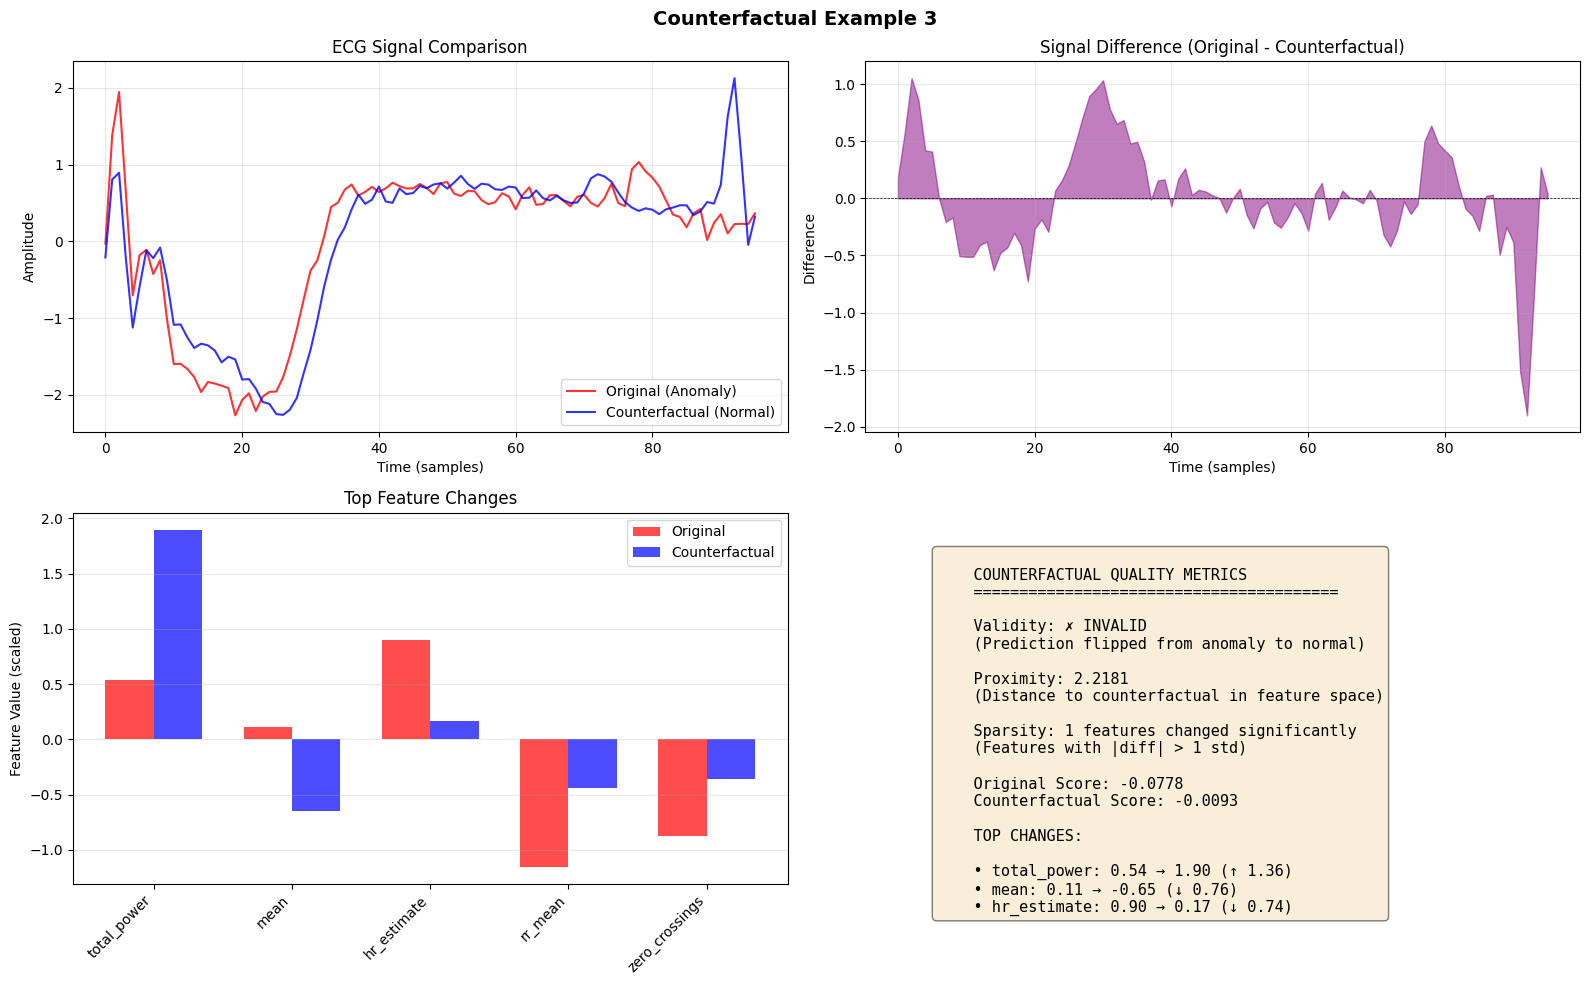

In [25]:
# visualise a few example counterfactuals
for i, cf in enumerate(counterfactuals[:3]):
    fig = visualize_counterfactual(cf, f"Counterfactual Example {i+1}")
    plt.savefig(f'counterfactual_example_{i+1}.png', dpi=150, bbox_inches='tight')
    plt.show()

## LLM Clinical Explanations

In [26]:
@dataclass
class ClinicalExplanation:
    flag_reason: str              # why did the AI flag this ECG
    key_differences: List[str]    # what is the main differences from normal (3 items)
    interpretation_note: str      # what is the clinical context for these differences
    confidence_statement: str     # how reliable is this assessment
    
    raw_response: str = ""
    model_used: str = ""
    tokens_used: int = 0
    generation_time: float = 0.0

In [27]:
class LLMExplanationGenerator:
    # clinical context for ECG features
    FEATURE_CLINICAL_CONTEXT = {
        'hr_estimate': ('Heart rate', 'BPM', 'Normal resting: 60-100 BPM'),
        'rr_mean': ('R-R interval (time between beats)', 'samples', 'Regularity indicates rhythm stability'),
        'rr_std': ('R-R variability', 'samples', 'Higher values suggest irregular rhythm'),
        'rr_min': ('Minimum R-R interval', 'samples', 'Very short intervals may indicate ectopic beats'),
        'rr_max': ('Maximum R-R interval', 'samples', 'Long intervals may indicate pauses or blocks'),
        'hrv': ('Heart rate variability', 'ratio', 'Reflects autonomic nervous system function'),
        'n_peaks': ('Number of detected heartbeats', 'count', 'Should match expected for recording duration'),
        'peak_height_mean': ('Average R-wave amplitude', 'normalized units', 'Changes may reflect conduction abnormalities'),
        'peak_height_std': ('R-wave amplitude variability', 'normalized units', 'Consistency of ventricular depolarization'),
        'mean': ('Signal mean', 'units', 'Baseline level of the ECG'),
        'std': ('Signal standard deviation', 'units', 'Overall variability in the signal'),
        'var': ('Signal variance', 'units', 'Squared variability measure'),
        'min': ('Signal minimum', 'units', 'Lowest point in the ECG'),
        'max': ('Signal maximum', 'units', 'Highest point (typically R-peak)'),
        'range': ('Signal range', 'units', 'Difference between max and min'),
        'median': ('Signal median', 'units', 'Central value of the signal'),
        'skewness': ('Waveform asymmetry', 'units', 'May indicate ST segment changes'),
        'kurtosis': ('Waveform peakedness', 'units', 'Related to QRS morphology'),
        'rms': ('Root mean square', 'units', 'Signal energy measure'),
        'zero_crossings': ('Zero crossings', 'count', 'Frequency-related measure'),
        'total_power': ('Total spectral power', 'units', 'Overall signal energy'),
        'vlf_power': ('Very low frequency power', 'ratio', 'Long-term regulatory mechanisms'),
        'lf_power': ('Low frequency power', 'ratio', 'Sympathetic and parasympathetic activity'),
        'hf_power': ('High frequency power', 'ratio', 'Parasympathetic (vagal) activity'),
        'dominant_freq': ('Dominant frequency', 'Hz', 'Primary frequency component'),
        'spectral_entropy': ('Signal complexity', 'units', 'Lower values suggest more regular patterns'),
        'lf_hf_ratio': ('LF/HF ratio', 'ratio', 'Sympathovagal balance indicator'),
    }

    SYSTEM_PROMPT = """You are a clinical decision support assistant that explains ECG anomaly detection results. Your role is NOT to diagnose or recommend actions—clinicians make those decisions. Your role is to explain WHY an AI system flagged an ECG as potentially abnormal.

You translate technical counterfactual explanations into clear language. A counterfactual explanation works by answering: "What would need to be different about this ECG for it to appear normal?"

AUDIENCE: Your explanations must be understood by cardiologists, general practitioners, and cardiac nurses—use precise but accessible language.

CRITICAL CONSTRAINTS:
- Never diagnose conditions or recommend clinical actions
- Never use phrases like "you should" or "this indicates [diagnosis]"
- Always frame explanations as "the AI flagged this because..." not "this patient has..."
- Keep the total explanation under 150 words
- Be honest about uncertainty—these are computational patterns, not clinical diagnoses

OUTPUT FORMAT: Return ONLY valid JSON with no additional text, markdown or explanation."""

    def __init__(self, config: PipelineConfig):
        self.config = config
        self._openai_client = None
        self._local_generator = None
        self._local_tokenizer = None

    
    def _format_feature_changes(self, cf: CounterfactualExplanation, top_n: int = 5) -> str:
        lines = []
        
        for name, orig_val, cf_val, diff in cf.top_changes[:top_n]:
            context = self.FEATURE_CLINICAL_CONTEXT.get(name, (name, 'units', ''))
            direction = "higher" if diff > 0 else "lower"
            abs_diff = abs(diff)
            
            line = f"- {context[0]}: This ECG is {abs_diff:.2f} {context[1]} {direction} than the normal reference. {context[2]}"
            lines.append(line)
        
        return "\n".join(lines)

    def _build_user_prompt(self, cf: CounterfactualExplanation) -> str:
        feature_changes_text = self._format_feature_changes(cf)
        
        # simple confidence indicator based on the proximity
        if cf.proximity < 2.0:
            confidence_hint = "relatively close to normal patterns"
        elif cf.proximity < 4.0:
            confidence_hint = "moderately different from normal patterns"
        else:
            confidence_hint = "substantially different from normal patterns"
        
        return f"""An ECG was flagged as potentially abnormal by an anomaly detection system. Below are the key differences between this ECG and the nearest "normal" reference ECG found by the system.

DETECTION INFO:
- Anomaly Score: {cf.original_score:.3f} (higher = more anomalous)
- Distance from nearest normal: {cf.proximity:.3f} ({confidence_hint})

FEATURE DIFFERENCES (what would need to change for this ECG to appear normal):
{feature_changes_text}

Translate this into a clinical explanation. Return ONLY valid JSON with exactly these fields:

{{
  "flag_reason": "One to two sentences explaining in plain English why the AI flagged this ECG as abnormal. Start with 'This ECG was flagged because...'",
  
  "key_differences": [
    "First key difference between this ECG and normal reference (one sentence)",
    "Second key difference (one sentence)", 
    "Third key difference if relevant, otherwise omit this item (one sentence)"
  ],
  
  "interpretation_note": "One sentence providing clinical context for these differences, accessible to non-specialists. Frame as 'These patterns may be associated with...' not as a diagnosis.",
  
  "confidence_statement": "One sentence about the reliability of this flag based on how different this ECG is from normal references."
}}"""

    def _parse_llm_response(self, response_text: str) -> dict:
        text = response_text.strip()
        
        # remove markdown blocks
        if text.startswith("```"):
            lines = text.split("\n")
            if lines[0].startswith("```"):
                lines = lines[1:]
            if lines and lines[-1].strip() == "```":
                lines = lines[:-1]
            text = "\n".join(lines)
        
        try:
            return json.loads(text)
        except json.JSONDecodeError:
            pass
        
        start = text.find('{')
        end = text.rfind('}')
        if start != -1 and end != -1 and end > start:
            try:
                return json.loads(text[start:end + 1])
            except json.JSONDecodeError:
                pass
        
        raise ValueError(f"Could not parse JSON from LLM response: {text[:200]}...")

    def _validate_response(self, data: dict) -> dict:
        required_fields = ['flag_reason', 'key_differences', 'interpretation_note', 'confidence_statement']
        
        for field in required_fields:
            if field not in data:
                raise ValueError(f"Missing required field: {field}")
        
        if not isinstance(data['key_differences'], list):
            data['key_differences'] = [str(data['key_differences'])]
        
        data['key_differences'] = data['key_differences'][:3]
        
        for field in ['flag_reason', 'interpretation_note', 'confidence_statement']:
            data[field] = str(data[field])
        
        return data

    def _generate_with_openai(self, cf: CounterfactualExplanation) -> Tuple[str, int]:
        if self._openai_client is None:
            try:
                from openai import OpenAI
            except ImportError:
                raise ImportError("openai package not installed. Run: pip install openai")
            
            api_key = os.getenv(self.config.llm_api_key_env)
            if not api_key:
                raise ValueError(f"OpenAI API key not found in environment variable: {self.config.llm_api_key_env}")
            
            self._openai_client = OpenAI(api_key=api_key)
        
        user_prompt = self._build_user_prompt(cf)
        
        response = self._openai_client.chat.completions.create(
            model=self.config.llm_model,
            messages=[
                {"role": "system", "content": self.SYSTEM_PROMPT},
                {"role": "user", "content": user_prompt}
            ],
            temperature=self.config.llm_temperature,
            max_tokens=self.config.llm_max_tokens,
            response_format={"type": "json_object"}  
        )
        
        response_text = response.choices[0].message.content
        tokens_used = response.usage.total_tokens if response.usage else 0
        
        return response_text, tokens_used

    # generate explanation for cf with structured fields
    def generate(self, cf: CounterfactualExplanation) -> ClinicalExplanation:
        start_time = time.perf_counter()
        
        backend = self.config.llm_backend.lower()
        
        try:
            if backend == 'openai':
                response_text, tokens_used = self._generate_with_openai(cf)
            elif backend == 'local':
                response_text, tokens_used = self._generate_with_local(cf)
            elif backend == 'gemini':
                response_text, tokens_used = self._generate_with_gemini(cf)
            else:
                raise ValueError(f"Unknown LLM backend: {backend}")
            
            data = self._parse_llm_response(response_text)
            data = self._validate_response(data)
            
            generation_time = time.perf_counter() - start_time
            
            return ClinicalExplanation(
                flag_reason=data['flag_reason'],
                key_differences=data['key_differences'],
                interpretation_note=data['interpretation_note'],
                confidence_statement=data['confidence_statement'],
                raw_response=response_text,
                model_used=self.config.llm_model if backend == 'openai' else self.config.llm_local_model,
                tokens_used=tokens_used,
                generation_time=generation_time
            )
            
        except Exception as e:
            generation_time = time.perf_counter() - start_time
            
            top_features = [name for name, _, _, _ in cf.top_changes[:3]]
            
            return ClinicalExplanation(
                flag_reason=f"",
                key_differences=f"",
                interpretation_note=f"",
                confidence_statement=f"",
                raw_response=f"",
                model_used=f"",
                tokens_used=0,
                generation_time=generation_time
            )

In [28]:
def display_clinical_explanation(cf: CounterfactualExplanation, explanation: ClinicalExplanation):
    print("\n" + "="*70)
    print("CLINICAL EXPLANATION REPORT")
    print("="*70)
    
    print(f"\n WHY WAS THIS FLAGGED?")
    print("-"*50)
    print(explanation.flag_reason)
    
    print(f"\n KEY DIFFERENCES FROM NORMAL")
    print("-"*50)
    for i, diff in enumerate(explanation.key_differences, 1):
        print(f"  {i}. {diff}")
    
    print(f"\n CLINICAL CONTEXT")
    print("-"*50)
    print(explanation.interpretation_note)
    
    print(f"\nCONFIDENCE")
    print("-"*50)
    print(explanation.confidence_statement)
    
    print(f"\n METADATA")
    print("-"*50)
    print(f"  Model: {explanation.model_used}")
    print(f"  Tokens: {explanation.tokens_used}")
    print(f"  Time: {explanation.generation_time:.2f}s")
    
    print("\n" + "="*70)

In [29]:
llm_generator = LLMExplanationGenerator(config)
api_key = os.getenv(config.llm_api_key_env)
if not api_key:
    print(f"Warning: {config.llm_api_key_env} not set")
    config.llm_backend = 'local'
else:
    print(f"API key found. Using {config.llm_model}")

print("Generating clinical explanations...\n")

for i, cf in enumerate(counterfactuals[:3]):
    print(f"\n{'#'*70}")
    print(f"# EXAMPLE {i+1}")
    print(f"{'#'*70}")
    
    explanation = llm_generator.generate(cf)
    display_clinical_explanation(cf, explanation)

API key found. Using gpt-4o-mini
Generating clinical explanations...


######################################################################
# EXAMPLE 1
######################################################################

CLINICAL EXPLANATION REPORT

 WHY WAS THIS FLAGGED?
--------------------------------------------------
This ECG was flagged because it shows significant differences from normal patterns, suggesting potential abnormalities in heart rhythm and conduction.

 KEY DIFFERENCES FROM NORMAL
--------------------------------------------------
  1. The minimum R-R interval is 3.80 samples shorter than normal, which may suggest ectopic beats.
  2. The signal median is 2.89 units higher than normal, indicating a shift in the central value of the signal.
  3. The average R-wave amplitude is 2.82 normalized units lower than normal, which could reflect conduction abnormalities.

 CLINICAL CONTEXT
--------------------------------------------------
These patterns may be associated 

## Explainable ECG Pipeline

In [30]:
@dataclass
class PipelineResult:
    ecg_signal: np.ndarray
    ecg_id: str
    
    #1. detection
    is_anomaly: bool
    anomaly_score: float
    detection_confidence: float
    
    #2. counterfactual 
    counterfactual: Optional[CounterfactualExplanation]
    
    #3. clinical explanation
    clinical_explanation: Optional[ClinicalExplanation]
    
    processing_time: float = 0.0

In [31]:
class ExplainableECGPipeline:
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.preprocessor = ECGPreprocessor(config)
        self.feature_extractor = ECGFeatureExtractor(config)
        self.feature_scaler = StandardScaler()
        self.if_detector = IsolationForestDetector(config)
        self.svm_detector = OneClassSVMDetector(config)
        self.ensemble_detector = EnsembleAnomalyDetector(
            detectors=[self.if_detector, self.svm_detector],
            aggregation='mean'
        )
        self.cf_generator: Optional[NearestNeighbourCounterfactual] = None
        self.llm_generator = LLMExplanationGenerator(config)
        self.score_scaler = MinMaxScaler()

    def fit(self, X_signals: np.ndarray, y: np.ndarray) -> "ExplainableECGPipeline":
        X_processed = self.preprocessor.preprocess(X_signals)
        X_features = self.feature_extractor.transform(X_processed)
        self.feature_scaler.fit(X_features)
        X_scaled = self.feature_scaler.transform(X_features)

        normal_mask = (y == 0)
        X_normal = X_scaled[normal_mask]
        self.if_detector.fit(X_normal)
        self.svm_detector.fit(X_normal)
        self.ensemble_detector.fit(X_normal)

        scores = self.ensemble_detector.decision_function(X_scaled).reshape(-1, 1)
        self.score_scaler.fit(scores)

        self.cf_generator = NearestNeighbourCounterfactual(
            config=self.config,
            detector=self.ensemble_detector,
            feature_names=self.feature_extractor.feature_names
        )
        self.cf_generator.fit(X_processed, X_scaled, y)
        return self

    def _confidence_from_score(self, score: float) -> float:
        scaled = self.score_scaler.transform([[score]])[0][0]
        return float(np.clip(scaled, 0.0, 1.0))

    def predict(self, ecg_signal: np.ndarray, ecg_id: str, 
                generate_explanation: bool = True) -> PipelineResult:
        start_time = time.perf_counter()
        
        X_processed = self.preprocessor.preprocess(ecg_signal)
        X_features = self.feature_extractor.transform(X_processed)
        X_scaled = self.feature_scaler.transform(X_features)

        is_anomaly = bool(self.ensemble_detector.predict(X_scaled)[0])
        anomaly_score = float(self.ensemble_detector.decision_function(X_scaled)[0])
        detection_confidence = self._confidence_from_score(anomaly_score)

        counterfactual = None
        clinical_explanation = None
        
        if is_anomaly and self.cf_generator is not None:
            counterfactual = self.cf_generator.generate(X_processed, X_scaled[0])
            
            if generate_explanation:
                clinical_explanation = self.llm_generator.generate(counterfactual)

        processing_time = time.perf_counter() - start_time

        return PipelineResult(
            ecg_signal=ecg_signal,
            ecg_id=ecg_id,
            is_anomaly=is_anomaly,
            anomaly_score=anomaly_score,
            detection_confidence=detection_confidence,
            counterfactual=counterfactual,
            clinical_explanation=clinical_explanation,
            processing_time=processing_time
        )

In [32]:
pipeline = ExplainableECGPipeline(config)
pipeline.fit(X_train, y_train)

Counterfactual generator fitted on 69 normal samples


In [33]:
print("\n" + "="*60)
print("RUNNING PIPELINE ON TEST SAMPLES")
print("="*60)

test_indices = [0, 1, 2]

for idx in test_indices:
    result = pipeline.predict(X_test[idx], f"TEST_{idx:04d}")
    
    print(f"\n{'='*60}")
    print(f"ECG ID: {result.ecg_id}")
    print(f"Ground Truth: {'Anomaly' if y_test[idx] == 1 else 'Normal'}")
    print(f"Prediction: {'Anomaly' if result.is_anomaly else 'Normal'}")
    print(f"Anomaly Score: {result.anomaly_score:.4f}")
    print(f"Detection Confidence: {result.detection_confidence:.2%}")
    print(f"Processing Time: {result.processing_time:.3f}s")
    
    if result.clinical_explanation:
        print(f"\n--- Clinical Explanation ---")
        print(f"Flag Reason: {result.clinical_explanation.flag_reason}")


RUNNING PIPELINE ON TEST SAMPLES

ECG ID: TEST_0000
Ground Truth: Normal
Prediction: Normal
Anomaly Score: -0.2072
Detection Confidence: 10.06%
Processing Time: 0.036s

ECG ID: TEST_0001
Ground Truth: Normal
Prediction: Normal
Anomaly Score: -0.0971
Detection Confidence: 26.75%
Processing Time: 0.035s

ECG ID: TEST_0002
Ground Truth: Normal
Prediction: Normal
Anomaly Score: -0.0249
Detection Confidence: 37.71%
Processing Time: 0.032s


## Pipeline Evaluation

In [34]:
def comprehensive_evaluation(pipeline: ExplainableECGPipeline, 
                             X_test: np.ndarray, y_test: np.ndarray) -> Dict:
    results = {}
    
    X_processed = pipeline.preprocessor.preprocess(X_test)
    X_features = pipeline.feature_extractor.transform(X_processed)
    X_scaled = pipeline.feature_scaler.transform(X_features)
    
    print("\n" + "="*60)
    print("DETECTION LAYER EVALUATION")
    print("="*60)
    
    y_pred = pipeline.ensemble_detector.predict(X_scaled)
    scores = pipeline.ensemble_detector.decision_function(X_scaled)
    
    results['detection'] = {
        'auroc': roc_auc_score(y_test, scores),
        'auprc': average_precision_score(y_test, scores),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    }
    
    print(f"\nMetrics:")
    for name, value in results['detection'].items():
        print(f"  {name.upper()}: {value:.4f}")
    
    print("\n" + "="*60)
    print("COUNTERFACTUAL LAYER EVALUATION")
    print("="*60)
    
    anomaly_indices = np.where(y_test == 1)[0]
    counterfactuals = []
    
    for idx in tqdm(anomaly_indices[:50], desc="Generating counterfactuals"):
        cf = pipeline.cf_generator.generate(X_processed[idx], X_scaled[idx])
        counterfactuals.append(cf)
    
    results['counterfactual'] = {
        'validity_rate': np.mean([cf.validity for cf in counterfactuals]),
        'mean_proximity': np.mean([cf.proximity for cf in counterfactuals]),
        'std_proximity': np.std([cf.proximity for cf in counterfactuals]),
        'mean_sparsity': np.mean([cf.sparsity for cf in counterfactuals])
    }
    
    print(f"\nMetrics (on {len(counterfactuals)} samples):")
    print(f"  Validity Rate: {results['counterfactual']['validity_rate']:.2%}")
    print(f"  Mean Proximity: {results['counterfactual']['mean_proximity']:.4f} ± {results['counterfactual']['std_proximity']:.4f}")
    print(f"  Mean Sparsity: {results['counterfactual']['mean_sparsity']:.1f} features")
    
    return results

In [35]:
evaluation_results = comprehensive_evaluation(pipeline, X_test, y_test)


DETECTION LAYER EVALUATION

Metrics:
  AUROC: 0.8220
  AUPRC: 0.7306
  F1: 0.7333
  PRECISION: 0.6111
  RECALL: 0.9167

COUNTERFACTUAL LAYER EVALUATION


Generating counterfactuals: 100%|██████████| 36/36 [00:03<00:00, 10.66it/s]


Metrics (on 36 samples):
  Validity Rate: 66.67%
  Mean Proximity: 4.7086 ± 3.1010
  Mean Sparsity: 5.5 features


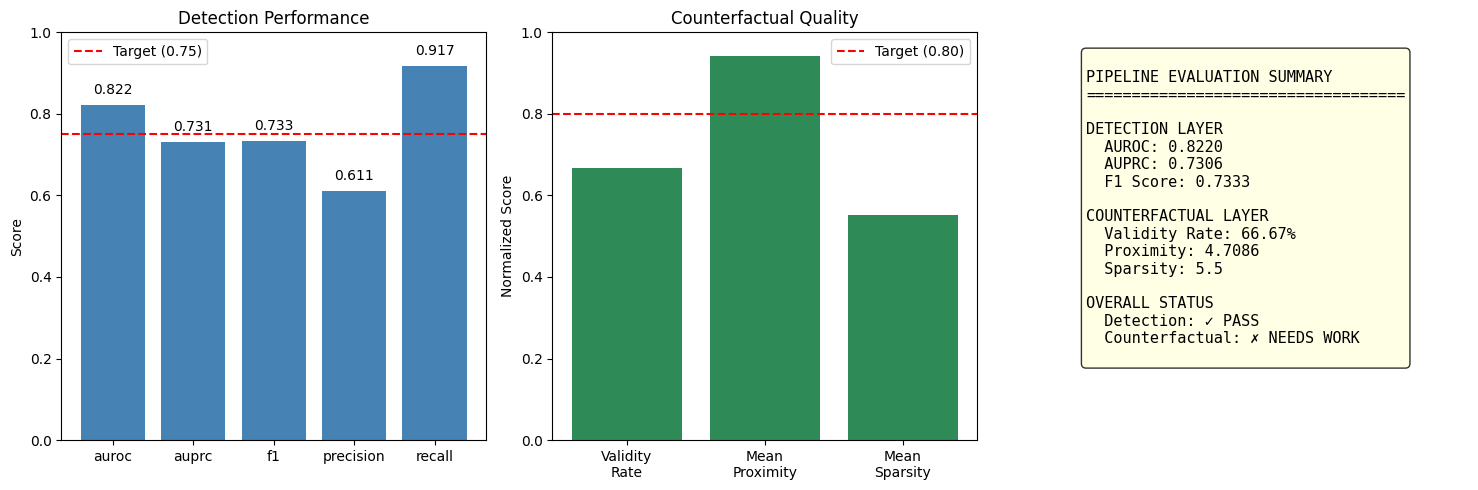

In [36]:
# visualise evaluation results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

detection_metrics = evaluation_results['detection']
ax1 = axes[0]
bars = ax1.bar(detection_metrics.keys(), detection_metrics.values(), color='steelblue')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Score')
ax1.set_title('Detection Performance')
ax1.axhline(y=0.75, color='r', linestyle='--', label='Target (0.75)')
ax1.legend()
for bar, val in zip(bars, detection_metrics.values()):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

cf_metrics = evaluation_results['counterfactual']
ax2 = axes[1]
cf_labels = ['Validity\nRate', 'Mean\nProximity', 'Mean\nSparsity']
cf_values = [cf_metrics['validity_rate'], 
             cf_metrics['mean_proximity'] / 5,
             cf_metrics['mean_sparsity'] / 10]
bars = ax2.bar(cf_labels, cf_values, color='seagreen')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Normalized Score')
ax2.set_title('Counterfactual Quality')
ax2.axhline(y=0.80, color='r', linestyle='--', label='Target (0.80)')
ax2.legend()

ax3 = axes[2]
ax3.axis('off')
summary_text = f"""
PIPELINE EVALUATION SUMMARY
{'='*35}

DETECTION LAYER
  AUROC: {detection_metrics['auroc']:.4f}
  AUPRC: {detection_metrics['auprc']:.4f}
  F1 Score: {detection_metrics['f1']:.4f}

COUNTERFACTUAL LAYER
  Validity Rate: {cf_metrics['validity_rate']:.2%}
  Proximity: {cf_metrics['mean_proximity']:.4f}
  Sparsity: {cf_metrics['mean_sparsity']:.1f}

OVERALL STATUS
  Detection: {'✓ PASS' if detection_metrics['auroc'] >= 0.75 else '✗ NEEDS WORK'}
  Counterfactual: {'✓ PASS' if cf_metrics['validity_rate'] >= 0.80 else '✗ NEEDS WORK'}
"""
ax3.text(0.1, 0.95, summary_text, transform=ax3.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('pipeline_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

## Generate Clinical Report

In [37]:
def generate_clinical_report(result: PipelineResult) -> str:
    report = f"""
╔══════════════════════════════════════════════════════════════════════╗
║                       ECG ANALYSIS REPORT                            ║
╠══════════════════════════════════════════════════════════════════════╣
║ ECG ID: {result.ecg_id:<60} ║
║ Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'):<52} ║
╠══════════════════════════════════════════════════════════════════════╣
║ DETECTION RESULT                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║ Classification: {'ABNORMAL' if result.is_anomaly else 'NORMAL':<57} ║
║ Anomaly Score: {result.anomaly_score:>8.4f}                                          ║
║ Confidence: {result.detection_confidence:>6.1%}                                             ║
╠══════════════════════════════════════════════════════════════════════╣
"""
    
    if result.is_anomaly and result.clinical_explanation:
        exp = result.clinical_explanation
        key_diff_text = "\n".join([f"  • {diff}" for diff in exp.key_differences])
        
        report += f"""
║ CLINICAL INTERPRETATION                                              ║
╠══════════════════════════════════════════════════════════════════════╣

WHY THIS ECG WAS FLAGGED:
{exp.flag_reason}

KEY DIFFERENCES FROM NORMAL:
{key_diff_text}

CLINICAL CONTEXT:
{exp.interpretation_note}

CONFIDENCE ASSESSMENT:
{exp.confidence_statement}

╠══════════════════════════════════════════════════════════════════════╣
║ This is AI-assisted analysis. Clinical judgment is required.      ║
║ This explanation is for decision support, not diagnosis.             ║
╚══════════════════════════════════════════════════════════════════════╝
"""
    else:
        report += """
║ No significant abnormalities detected by the AI system.              ║
║ Standard clinical follow-up as indicated.                            ║
╚══════════════════════════════════════════════════════════════════════╝
"""
    
    return report

In [38]:
print("\n" + "#"*70)
print("#" + " "*22 + "CLINICAL CASE STUDIES" + " "*23 + "#")
print("#"*70)

# find the correctly detected anomalies
detected_anomalies = [
    i for i in range(len(X_test)) 
    if y_test[i] == 1 and pipeline.ensemble_detector.predict(
        pipeline.feature_scaler.transform(
            pipeline.feature_extractor.transform(
                pipeline.preprocessor.preprocess(X_test[i:i+1])
            )
        )
    )[0] == 1
]

print(f"\nFound {len(detected_anomalies)} correctly detected anomalies.")


######################################################################
#                      CLINICAL CASE STUDIES                       #
######################################################################

Found 33 correctly detected anomalies.



╔══════════════════════════════════════════════════════════════════════╗
║                       ECG ANALYSIS REPORT                            ║
╠══════════════════════════════════════════════════════════════════════╣
║ ECG ID: CASE_001                                                     ║
║ Analysis Date: 2026-01-23 14:09:07                                  ║
╠══════════════════════════════════════════════════════════════════════╣
║ DETECTION RESULT                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║ Classification: ABNORMAL                                                  ║
║ Anomaly Score:   0.3203                                          ║
║ Confidence:  90.0%                                             ║
╠══════════════════════════════════════════════════════════════════════╣

║ CLINICAL INTERPRETATION                                              ║
╠═════════════════════════════════════════════════════

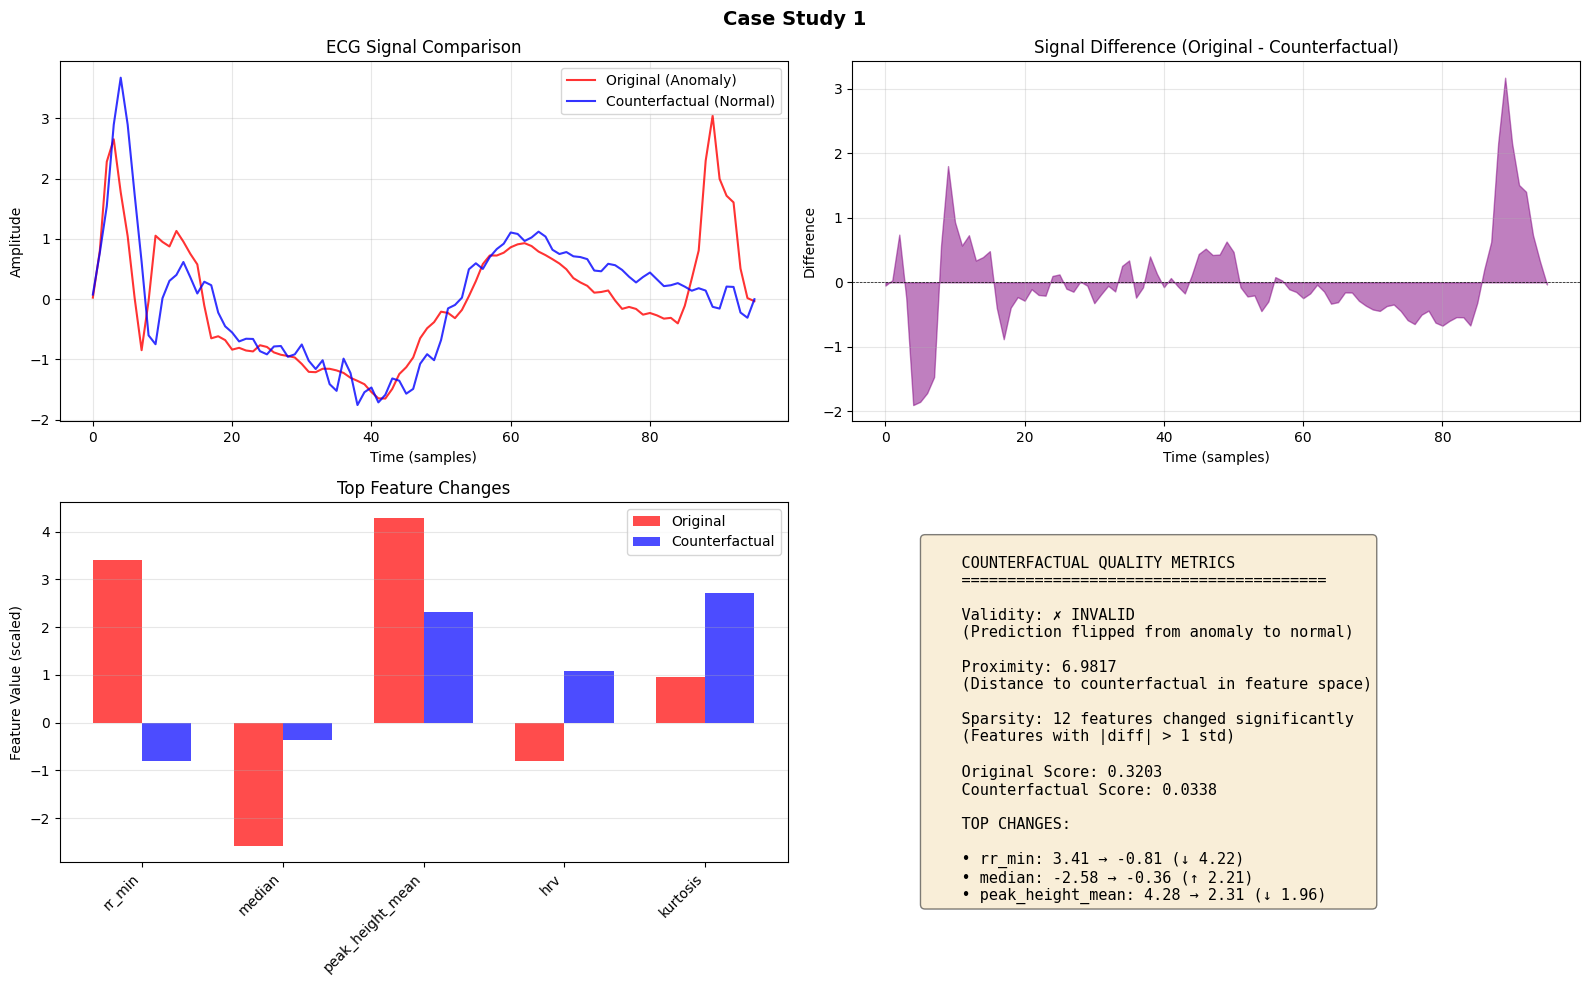


╔══════════════════════════════════════════════════════════════════════╗
║                       ECG ANALYSIS REPORT                            ║
╠══════════════════════════════════════════════════════════════════════╣
║ ECG ID: CASE_002                                                     ║
║ Analysis Date: 2026-01-23 14:09:13                                  ║
╠══════════════════════════════════════════════════════════════════════╣
║ DETECTION RESULT                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║ Classification: ABNORMAL                                                  ║
║ Anomaly Score:   0.0359                                          ║
║ Confidence:  46.9%                                             ║
╠══════════════════════════════════════════════════════════════════════╣

║ CLINICAL INTERPRETATION                                              ║
╠═════════════════════════════════════════════════════

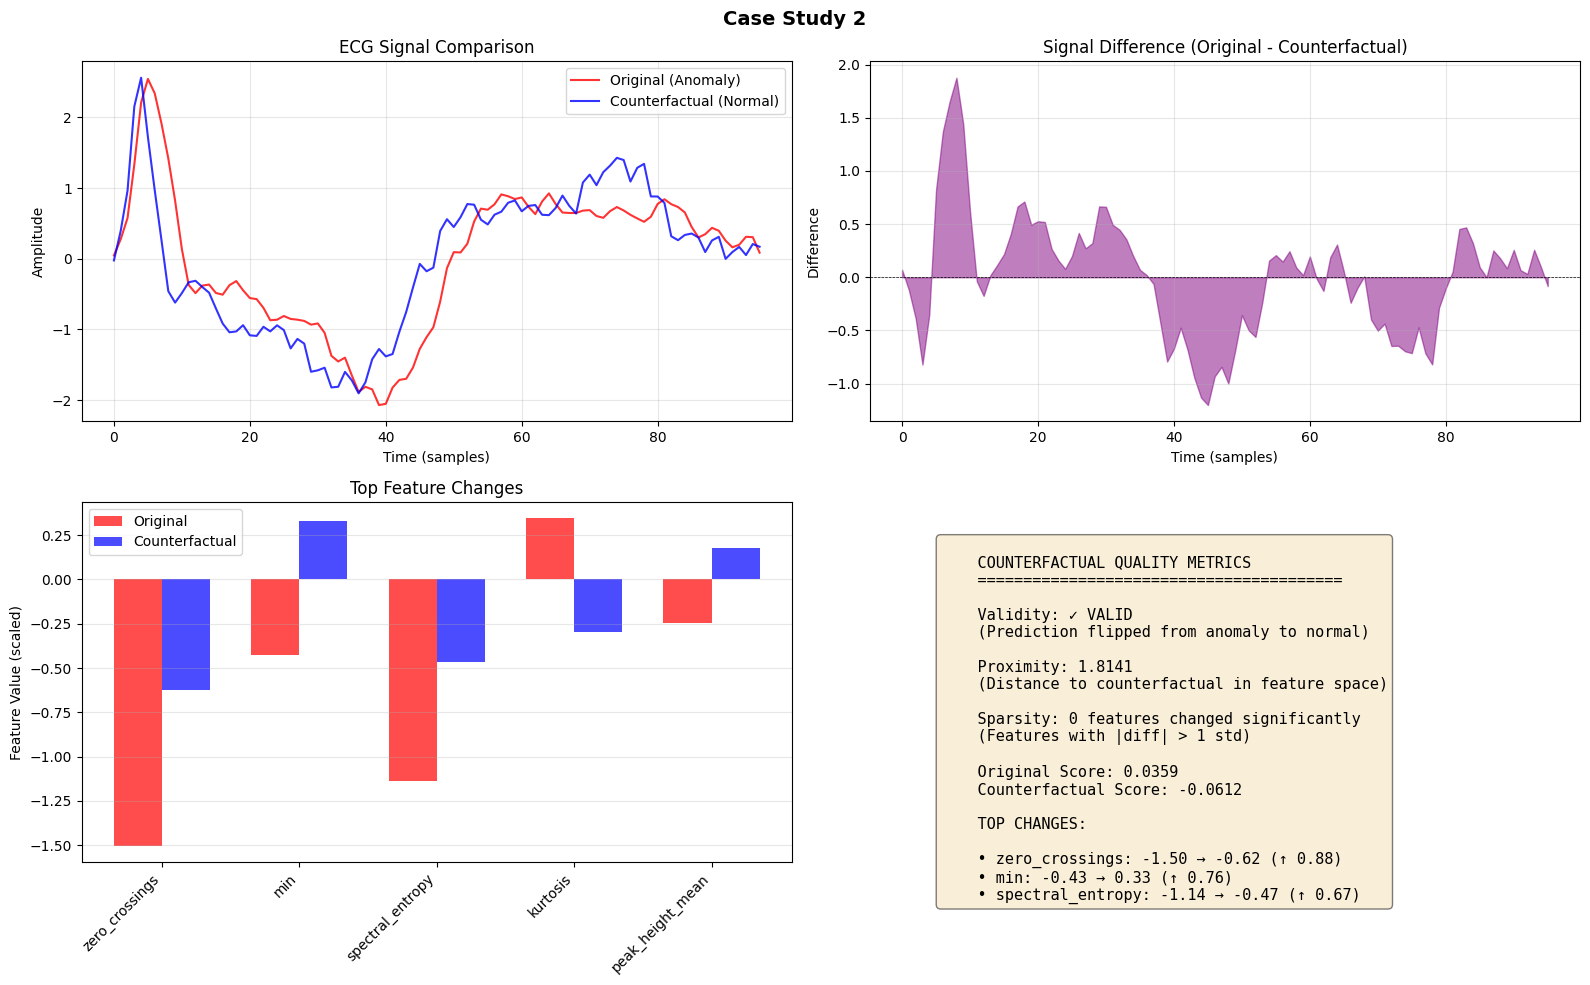

In [39]:
for i, idx in enumerate(detected_anomalies[:2]):
    result = pipeline.predict(X_test[idx], f"CASE_{i+1:03d}")
    report = generate_clinical_report(result)
    print(report)
    
    if result.counterfactual:
        fig = visualize_counterfactual(result.counterfactual, f"Case Study {i+1}")
        plt.savefig(f'case_study_{i+1}.png', dpi=150, bbox_inches='tight')
        plt.show()

## Export Results

In [40]:
def _to_jsonable(obj):
    if isinstance(obj, dict):
        return {str(k): _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [_to_jsonable(v) for v in obj]
    if isinstance(obj, np.ndarray):
        return [_to_jsonable(v) for v in obj.tolist()]
    if isinstance(obj, np.generic):
        return obj.item()
    return obj

In [41]:
def export_explanations_for_evaluation(pipeline: ExplainableECGPipeline,
                                       X_test: np.ndarray, 
                                       y_test: np.ndarray,
                                       n_samples: int = 20,
                                       output_path: str = "explanations_for_evaluation.json") -> List[Dict]:
    anomaly_indices = np.where(y_test == 1)[0]
    
    if len(anomaly_indices) < n_samples:
        n_samples = len(anomaly_indices)
    
    np.random.seed(RANDOM_STATE)
    selected_indices = np.random.choice(anomaly_indices, size=n_samples, replace=False)
    
    evaluation_data = []
    
    print(f"Generating {n_samples} explanations for evaluation...")
    
    for i, idx in enumerate(tqdm(selected_indices)):
        result = pipeline.predict(X_test[idx], f"EVAL_{i:03d}")
        
        if result.clinical_explanation and result.counterfactual:
            exp = result.clinical_explanation
            cf = result.counterfactual
            
            record = {
                "id": result.ecg_id,
                "sample_index": int(idx),
                "ground_truth": "anomaly",
                "predicted": "anomaly" if result.is_anomaly else "normal",
                "anomaly_score": round(result.anomaly_score, 4),
                "detection_confidence": round(result.detection_confidence, 4),
                
                "explanation": {
                    "flag_reason": exp.flag_reason,
                    "key_differences": exp.key_differences,
                    "interpretation_note": exp.interpretation_note,
                    "confidence_statement": exp.confidence_statement
                },
                
                # cf quality metrics
                "counterfactual_metrics": {
                    "validity": cf.validity,
                    "proximity": round(cf.proximity, 4),
                    "sparsity": cf.sparsity
                },
                
                # top feature changes 
                "top_feature_changes": [
                    {
                        "feature": name,
                        "original_value": round(orig, 4),
                        "counterfactual_value": round(cf_val, 4),
                        "difference": round(diff, 4)
                    }
                    for name, orig, cf_val, diff in cf.top_changes[:5]
                ],
                
                "model_used": exp.model_used,
                "generation_time": round(exp.generation_time, 3)
            }
            
            evaluation_data.append(_to_jsonable(record))

    with open(output_path, 'w') as f:
        json.dump(evaluation_data, f, indent=2)
    
    print(f"\nExported {len(evaluation_data)} explanations to: {output_path}")
    
    return evaluation_data

In [42]:
evaluation_export = export_explanations_for_evaluation(
    pipeline, X_test, y_test, 
    n_samples=min(20, len(np.where(y_test == 1)[0])),
    output_path="explanations_for_evaluation.json"
)

print("\nSample evaluation record:")
print(json.dumps(evaluation_export[0], indent=2))

Generating 20 explanations for evaluation...


100%|██████████| 20/20 [01:18<00:00,  3.94s/it]


Exported 19 explanations to: explanations_for_evaluation.json

Sample evaluation record:
{
  "id": "EVAL_000",
  "sample_index": 98,
  "ground_truth": "anomaly",
  "predicted": "anomaly",
  "anomaly_score": 0.2926,
  "detection_confidence": 0.8582,
  "explanation": {
    "flag_reason": "This ECG was flagged because it shows significant deviations from normal patterns in several key features.",
    "key_differences": [
      "The very low frequency power is 2.38 times lower than the normal reference, suggesting altered long-term regulatory mechanisms.",
      "The heart rate is 2.11 BPM lower than the normal reference, which is below the typical resting range of 60-100 BPM.",
      "The maximum R-R interval is 1.94 samples higher than the normal reference, indicating potential pauses or blocks in heart rhythm."
    ],
    "interpretation_note": "These patterns may be associated with variations in heart function and rhythm stability.",
    "confidence_statement": "The AI's flag is based

## Save Pipeline Components

In [43]:
import pickle

pipeline_components = {
    'config': config,
    'feature_scaler': pipeline.feature_scaler,
    'feature_names': pipeline.feature_extractor.feature_names,
    'if_detector': pipeline.if_detector,
    'svm_detector': pipeline.svm_detector,
}

with open('pipeline_components.pkl', 'wb') as f:
    pickle.dump(pipeline_components, f)

print("Pipeline components saved to 'pipeline_components.pkl'")

Pipeline components saved to 'pipeline_components.pkl'
